In [1]:
# packages
import numpy as np
import tensorflow
import scipy.ndimage
import tifffile 
import os
import matplotlib.pyplot as plt
import PIL
from mpl_toolkits.axes_grid1 import make_axes_locatable
% matplotlib inline 

In [2]:
# constants
image_width = 40000
separate_width = 500 # It will separate the original image in 6400 images 500 x 500 
length_classification = 20
total_images =  image_width / separate_width

# custom flags
show_image = False
cut_and_save_images = False

# custom path and coordinate
data_path = "C:/Users/IBM_ADMIN/workspace/pfc" # Change to your data folder 
coordinates = {"lat": "20S", "lon": "070W"}
dir_name = coordinates["lat"] + coordinates["lon"]

# file paths
tree_cover_path = "{0}/Hansen_GFC2015_treecover2000_{1}_{2}.tif".format(data_path, coordinates["lat"], coordinates["lon"])
first_path = "{0}/Hansen_GFC2015_first_{1}_{2}.tif".format(data_path, coordinates["lat"], coordinates["lon"])
last_path = "{0}/Hansen_GFC2015_last_{1}_{2}.tif".format(data_path, coordinates["lat"], coordinates["lon"])
loss_path = "{0}/Hansen_GFC2015_path_{1}_{2}.tif".format(data_path, coordinates["lat"], coordinates["lon"])

In [3]:
def cut_and_save(directory, name, matrix, length):
    try:
        os.makedirs("{0}/numpy_files/".format(data_path))
    except FileExistsError:
        pass 
    try:
        os.makedirs("{0}/numpy_files/{1}".format(data_path, directory))
    except FileExistsError:
        pass
    
    limit = int(len(matrix) / length)
    for i in range(limit):
        for j in range(limit):
            sub_matrix = matrix[i * length : i * length + length, j * length : j * length + length]
            np.save("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, directory, name, i, j), sub_matrix)

In [4]:
def separate_matrix(matrix, length):
    list_matrix = list()
    limit = int(len(matrix) / length)
    for i in range(limit):
        for j in range(limit):
            sub_matrix = matrix[i * length : i * length + length, j * length : j * length + length]
            list_matrix.append(sub_matrix)
    return list_matrix

In [5]:
def open_images(directory, name, total):
    list_matrix = list()
    for i in range(total):
        for j in range(total):
            sub_matrix = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, directory, name, i, j))
            list_matrix.append(sub_matrix)
    return list_matrix


def return_feature(directory, name, length, i, j):
    list_features = list()
    sub_matrix = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, directory, name, i, j))
    limit = int(len(sub_matrix) / length)
    for u in range(limit):
        for v in range(limit):
            sub_matrix_current = sub_matrix[u * length : u * length + length, v * length : v * length + length]
            mean_colors = sub_matrix_current.mean(0).mean(0)
            var_colors = sub_matrix_current.var(0).var(0)
            list_features.append(mean_colors.tolist() + var_colors.tolist())
    return list_features
            
    
def open_features(directory, name, total, length):
    list_features = list()
    for i in range(total):
        for j in range(total):
            list_features += return_feature(directory, name, length, i, j)
    return list_features


def classification_criteria(directory, name, length, i, j):
    list_classification = list()
    sub_matrix = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, directory, name, i, j))
    limit = int(len(sub_matrix) / length)
    for u in range(limit):
        for v in range(limit):
            sub_matrix_current = sub_matrix[u * length : u * length + length, v * length : v * length + length]
            list_classification.append(int((np.mean(sub_matrix_current) + 1) / 10))               
    return list_classification
    
    
def open_classifications(directory, name, total, length):
    list_classification = list()
    for i in range(total):
        for j in range(total):
            list_classification += classification_criteria(directory, name, length, i, j)
    return list_classification

In [6]:
# open, cut and save the first image: 
if cut_and_save_images:
    first_image = tifffile.imread(first_path)
    cut_and_save(dir_name, "first", first_image, separate_width)
    first_image = np.NaN # release memory

In [7]:
# open, cut and save the tree cover: 
if cut_and_save_images:
    treee_cover_image = tifffile.imread(tree_cover_path)
    cut_and_save(dir_name, "treecover", treee_cover_image, separate_width)
    treee_cover_image = np.NaN # release memory

In [8]:
features_example = return_feature(dir_name, "first", length_classification, 20, 20)
print("Features:\n-----------------\nMean 1 = {0}\nMean 2 = {1}\nMean 3 = {2}\nMean 4 = {3}"
      .format(features_example[0][0], features_example[0][1], features_example[0][2], features_example[0][3]))

Features:
-----------------
Mean 1 = 151.6625
Mean 2 = 93.99999999999999
Mean 3 = 166.3075
Mean 4 = 179.14999999999998


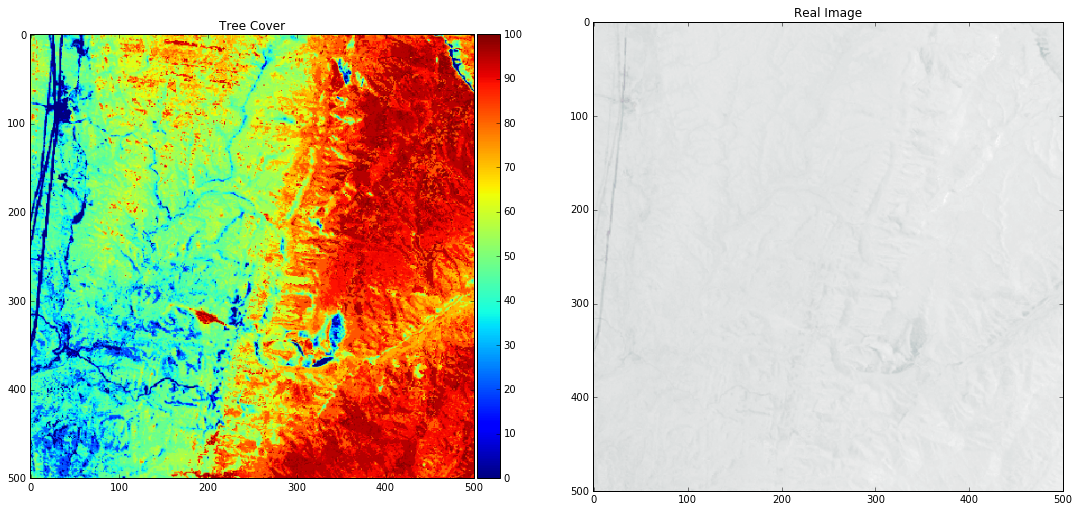

In [9]:
# tree cover anotation in cell (40, 40)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

tree_cover_example = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, dir_name, "treecover", 40, 40))
im1 = ax1.imshow(PIL.Image.fromarray(tree_cover_example))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_title("Tree Cover")

# image cell (40, 40)
image_example = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, dir_name, "first", 40, 40))
w, h, d = image_example.shape
pil_image = PIL.Image.frombytes("RGBA", (w, h), image_example.tostring())

im2 = ax2.imshow(pil_image)
ax2.set_title("Real Image")

In [10]:
# get features from all sub-images
all_features = open_features(dir_name, "first", int(total_images), length_classification)

# get the labels from all sub-images
all_labels = open_classifications(dir_name, "treecover", int(total_images), length_classification)

In [42]:
# separating the data in train and test
train_data_x = all_features[0 : int(len(all_features) / 2)]
train_data_y = all_labels[0 : int(len(all_labels) / 2)]
test_data_x = all_features[int(len(all_features) / 2) : int(len(all_features))]
test_data_y = all_labels[int(len(all_features) / 2) : int(len(all_labels))]

In [53]:
def success(predicted, result):
    compare = predicted == result
    count_true = 0
    count_false = 0
    for equal in compare:  
        if equal:
            count_true += 1
        else:
            count_false += 1
    return count_true / (count_true + count_false)


def compose_matrix(class_list, image_width, separate_width, length_classification):
    limit = int(image_width / length_classification)
    matrix = list()
    for i in range(limit):
        matrix.append(limit * [-1])
    row_block_length = int(separate_width / length_classification)
    num_block_row = int(image_width / separate_width)
    for i in range(len(class_list)):
        block_num = int(i / (row_block_length * row_block_length))
        u = block_num // num_block_row
        v = block_num % num_block_row
        r = i % (row_block_length * row_block_length)
        x = u * row_block_length + r / (row_block_length)
        y = v * row_block_length + r % (row_block_length)
        matrix[int(x)][int(y)] = class_list[i]
    return matrix

In [51]:
# linear classifier - SGD
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", n_iter=10, n_jobs=1)
clf.fit(train_data_x, train_data_y)
print("Success = {0}".format(success(clf.predict(test_data_x), test_data_y)))

Success = 0.616761


In [54]:
# apply classifier in all data
class_list = clf.predict(all_features)
classified_image = compose_matrix(class_list, image_width, separate_width, length_classification)

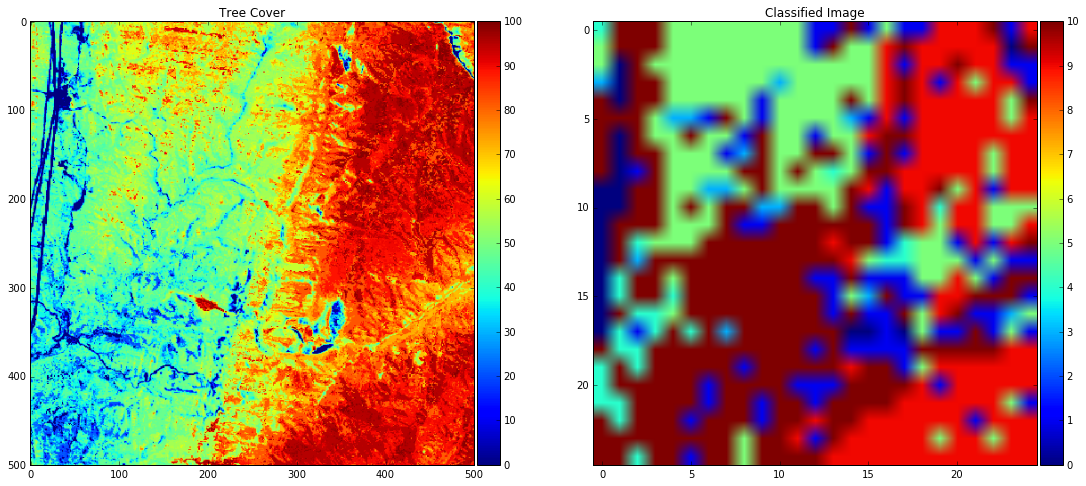

In [67]:
# compare treecover and classfied data
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

tree_cover_example = np.load("{0}/numpy_files/{1}/{2}-{3}-{4}.npy".format(data_path, dir_name, "treecover", 40, 40))
im1 = ax1.imshow(PIL.Image.fromarray(tree_cover_example))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_title("Tree Cover")

# image cell (40, 40)
limit = int(separate_width / length_classification)
class_matrix = list()
for i in range(limit):
    new_row = list()
    for j in range(limit):
        new_row.append(classified_image[40 * limit + i]
                       [40 * limit  + j])
    class_matrix.append(new_row)
im2 = ax2.imshow(class_matrix)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)
ax2.set_title("Classified Image")